(schelling)=
```{raw} html
<div id="qe-notebook-header" align="right" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" width="250px" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```

# Racial Segregation

```{index} single: Schelling Segregation Model
```

```{index} single: Models; Schelling's Segregation Model
```

## Outline

In 1969, Thomas C. Schelling developed a simple but striking model of racial
segregation {cite}`Schelling1969`.

His model studies the dynamics of racially mixed neighborhoods.

Like much of Schelling's work, the model shows how local interactions can lead
to surprising aggregate outcomes.

It studies a setting where agents (think of households) have relatively mild
preference for neighbors of the same race.

For example, these agents might be comfortable with a mixed race neighborhood
but uncomfortable when they feel "surrounded" by people from a different race.

Schelling illustrated the follow surprising result: in such a setting, mixed
race neighborhoods are likely to be unstable, tending to collapse over time.

In fact the model predicts strongly divided neighborhoods, with high levels of
segregation.

In other words, extreme segregation outcomes arise even though people's
preferences are not particularly extreme.

These extreme outcomes happen because of *interactions* between agents in the
model (e.g., households in a city) that drive self-reinforcing dynamics in the
model.

These ideas will become clearer as the lecture unfolds.

In recognition of his work on segregation and other research, Schelling was
awarded the 2005 Nobel Prize in Economic Sciences (joint with Robert Aumann).


Let's start with some imports:

In [1]:
import matplotlib.pyplot as plt
from random import uniform, seed
from math import sqrt
import numpy as np

## The model

In this section we will build a version of Schelling's model.

### Set-Up

We will cover a variation of Schelling's model that is different from the
original but also easy to program and, at the same time, captures his main
idea.

Suppose we have two types of people: orange people and green people.

Assume there are $n$ of each type.

These agents all live on a single unit square.

Thus, the location (e.g, address) of an agent is just a point $(x, y)$,  where
$0 < x, y < 1$.

* The set of all points $(x,y)$ satisfying $0 < x, y < 1$ is called the **unit square**
* Below we denote the unit square by $S$

### Preferences

We will say that an agent is *happy* if 5 or more of her 10 nearest neighbors are of the same type.

An agent who is not happy is called *unhappy*.

For example,

*  if an agent is orange and 5 of her 10 nearest neighbors are orange, then she is happy.
*  if an agent is green and 8 of her 10 nearest neighbors are orange, then she is unhappy.

'Nearest' is in terms of [Euclidean distance](https://en.wikipedia.org/wiki/Euclidean_distance).

An important point to note is that agents are **not** averse to living in mixed areas.

They are perfectly happy if half of their neighbors are of the other color.

### Behavior

Initially, agents are mixed together (integrated).

In particular, we assume that the initial location of each agent is an
independent draw from a bivariate uniform distribution on the unit square $S$.

* First their $x$ coordinate is drawn from a uniform distribution on $(0,1)$
* Then, independently, their $y$ coordinate is drawn from the same distribution.

Now, cycling through the set of all agents, each agent is now given the chance to stay or move.

Each agent stays if they are happy and moves if they are unhappy.

The algorithm for moving is as follows

```{prf:algorithm} Jump Chain Algorithm
:label: move_algo

1. Draw a random location in $S$
1. If happy at new location, move there
1. Otherwise, go to step 1

```

We cycle continuously through the agents, each time allowing an unhappy agent
to move.

We continue to cycle until no one wishes to move.

## Results

Let's now implement and run this simulation.

In what follows, agents are modeled as [objects](https://python-programming.quantecon.org/python_oop.html).

Here's an indication of their structure:

```{code-block} none
* Data:

    * type (green or orange)
    * location

* Methods:

    * determine whether happy or not given locations of other agents
    * If not happy, move
        * find a new location where happy
```

Let's build them.

In [2]:
class Agent:

    def __init__(self, type):
        self.type = type
        self.draw_location()

    def draw_location(self):
        self.location = uniform(0, 1), uniform(0, 1)

    def get_distance(self, other):
        "Computes the euclidean distance between self and other agent."
        a = (self.location[0] - other.location[0])**2
        b = (self.location[1] - other.location[1])**2
        return sqrt(a + b)

    def happy(self,
                agents,                # List of other agents
                num_neighbors=10,      # No. of agents viewed as neighbors
                require_same_type=5):  # How many neighbors must be same type
        """
            True if a sufficient number of nearest neighbors are of the same
            type.
        """

        distances = []

        # Distances is a list of pairs (d, agent), where d is distance from
        # agent to self
        for agent in agents:
            if self != agent:
                distance = self.get_distance(agent)
                distances.append((distance, agent))

        # Sort from smallest to largest, according to distance
        distances.sort()

        # Extract the neighboring agents
        neighbors = [agent for d, agent in distances[:num_neighbors]]

        # Count how many neighbors have the same type as self
        num_same_type = sum(self.type == agent.type for agent in neighbors)
        return num_same_type >= require_same_type

    def update(self, agents):
        "If not happy, then randomly choose new locations until happy."
        while not self.happy(agents):
            self.draw_location()

Here's some code that takes a list of agents and produces a plot showing their
locations on the unit square.

Orange agents are represented by orange dots and green ones are represented by
green dots.

In [3]:
def plot_distribution(agents, cycle_num):
    "Plot the distribution of agents after cycle_num rounds of the loop."
    x_values_0, y_values_0 = [], []
    x_values_1, y_values_1 = [], []
    # == Obtain locations of each type == #
    for agent in agents:
        x, y = agent.location
        if agent.type == 0:
            x_values_0.append(x)
            y_values_0.append(y)
        else:
            x_values_1.append(x)
            y_values_1.append(y)
    fig, ax = plt.subplots()
    plot_args = {'markersize': 8, 'alpha': 0.8}
    ax.set_facecolor('azure')
    ax.plot(x_values_0, y_values_0,
        'o', markerfacecolor='orange', **plot_args)
    ax.plot(x_values_1, y_values_1,
        'o', markerfacecolor='green', **plot_args)
    ax.set_title(f'Cycle {cycle_num-1}')
    plt.show()

And here's some pseudocode for the main loop, where we cycle through the
agents until no one wishes to move.

The pseudocode is

```{code-block} none
plot the distribution
while agents are still moving
    for agent in agents
        give agent the opportunity to move
plot the distribution
```

The real code is below

In [4]:
def run_simulation(num_of_type_0=600,
                   num_of_type_1=600,
                   max_iter=100_000,       # Maximum number of iterations
                   set_seed=1234):

    # Set the seed for reproducibility
    seed(set_seed)

    # Create a list of agents of type 0
    agents = [Agent(0) for i in range(num_of_type_0)]
    # Append a list of agents of type 1
    agents.extend(Agent(1) for i in range(num_of_type_1))

    # Initialize a counter
    count = 1

    # Plot the initial distribution
    plot_distribution(agents, count)

    # Loop until no agent wishes to move
    while count < max_iter:
        print('Entering loop ', count)
        count += 1
        no_one_moved = True
        for agent in agents:
            old_location = agent.location
            agent.update(agents)
            if agent.location != old_location:
                no_one_moved = False
        if no_one_moved:
            break

    # Plot final distribution
    plot_distribution(agents, count)

    if count < max_iter:
        print(f'Converged after {count} iterations.')
    else:
        print('Hit iteration bound and terminated.')


Let's have a look at the results.

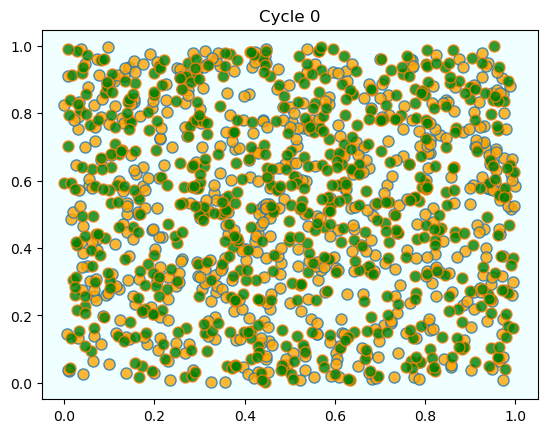

Entering loop  1


Entering loop  2


Entering loop  3


Entering loop  4


Entering loop  5


Entering loop  6


Entering loop  7


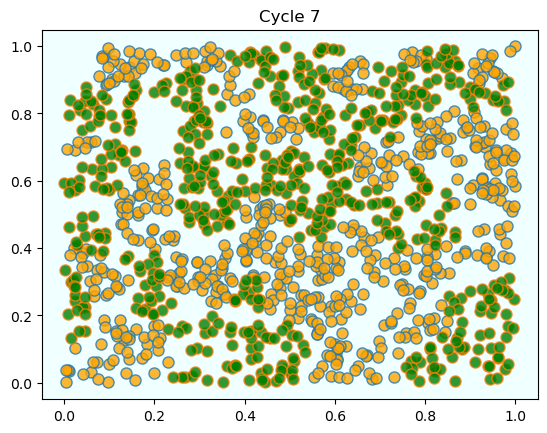

Converged after 8 iterations.


In [5]:
run_simulation()

As discussed above, agents are initially mixed randomly together.

But after several cycles, they become segregated into distinct regions.

In this instance, the program terminated after a small number of cycles
through the set of agents, indicating that all agents had reached a state of
happiness.

What is striking about the pictures is how rapidly racial integration breaks down.

This is despite the fact that people in the model don't actually mind living mixed with the other type.

Even with these preferences, the outcome is a high degree of segregation.



## Exercises

```{exercise-start}
:label: schelling_ex1
```

The object oriented style that we used for coding above is neat but harder to
optimize than procedural code (i.e., code based around functions rather than
objects and methods).

Try writing a new version of the model that stores

* the locations of all agents as a 2D NumPy array of floats.
* the types of all agents as a flat NumPy array of integers.

Write functions that act on this data to update the model using the logic
similar to that described above.

However, implement the following two changes:

1. Agents are offered a move at random (i.e., selected randomly and given the
   opportunity to move).
2. After an agent has moved, flip their type with probability 0.01

The second change introduces extra randomness into the model.

(We can imagine that, every so often, an agent moves to a different city and,
with small probability, is replaced by an agent of the other type.)

```{exercise-end}
```

```{solution-start} schelling_ex1
:class: dropdown
```
solution here

In [6]:
from numpy.random import uniform, randint

n = 1000                # number of agents (agents = 0, ..., n-1)
k = 10                  # number of agents regarded as neighbors
require_same_type = 5   # want >= require_same_type neighbors of the same type

def initialize_state():
    locations = uniform(size=(n, 2))
    types = randint(0, high=2, size=n)   # label zero or one
    return locations, types


def compute_distances_from_loc(loc, locations):
    """ Compute distance from location loc to all other points. """
    return np.linalg.norm(loc - locations, axis=1)

def get_neighbors(loc, locations):
    " Get all neighbors of a given location. "
    all_distances = compute_distances_from_loc(loc, locations)
    indices = np.argsort(all_distances)   # sort agents by distance to loc
    neighbors = indices[:k]               # keep the k closest ones
    return neighbors

def is_happy(i, locations, types):
    happy = True
    agent_loc = locations[i, :]
    agent_type = types[i]
    neighbors = get_neighbors(agent_loc, locations)
    neighbor_types = types[neighbors]
    if sum(neighbor_types == agent_type) < require_same_type:
        happy = False
    return happy

def count_happy(locations, types):
    " Count the number of happy agents. "
    happy_sum = 0
    for i in range(n):
        happy_sum += is_happy(i, locations, types)
    return happy_sum

def update_agent(i, locations, types):
    " Move agent if unhappy. "
    moved = False
    while not is_happy(i, locations, types):
        moved = True
        locations[i, :] = uniform(), uniform()
    return moved

def plot_distribution(locations, types, title, savepdf=False):
    " Plot the distribution of agents after cycle_num rounds of the loop."
    fig, ax = plt.subplots()
    colors = 'orange', 'green'
    for agent_type, color in zip((0, 1), colors):
        idx = (types == agent_type)
        ax.plot(locations[idx, 0],
                locations[idx, 1],
                'o',
                markersize=8,
                markerfacecolor=color,
                alpha=0.8)
    ax.set_title(title)
    plt.show()

def sim_random_select(max_iter=100_000, flip_prob=0.01, test_freq=10_000):
    """
    Simulate by randomly selecting one household at each update.

    Flip the color of the household with probability `flip_prob`.

    """

    locations, types = initialize_state()
    current_iter = 0

    while current_iter <= max_iter:

        # Choose a random agent and update them
        i = randint(0, n)
        moved = update_agent(i, locations, types)

        if flip_prob > 0:
            # flip agent i's type with probability epsilon
            U = uniform()
            if U < flip_prob:
                current_type = types[i]
                types[i] = 0 if current_type == 1 else 1

        # Every so many updates, plot and test for convergence
        if current_iter % test_freq == 0:
            cycle = current_iter / n
            plot_distribution(locations, types, f'iteration {current_iter}')
            if count_happy(locations, types) == n:
                print(f"Converged at iteration {current_iter}")
                break

        current_iter += 1

    if current_iter > max_iter:
        print(f"Terminating at iteration {current_iter}")

```{solution-end}
```

When we run this we again find that mixed neighborhoods break down and segregation emerges.

Here's a sample run.

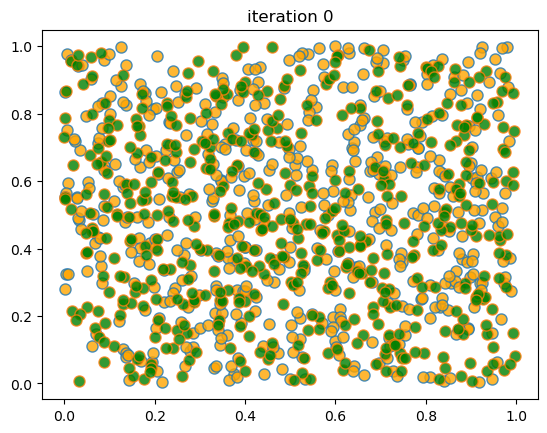

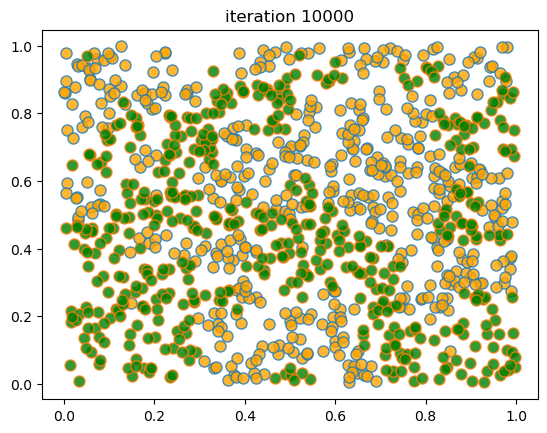

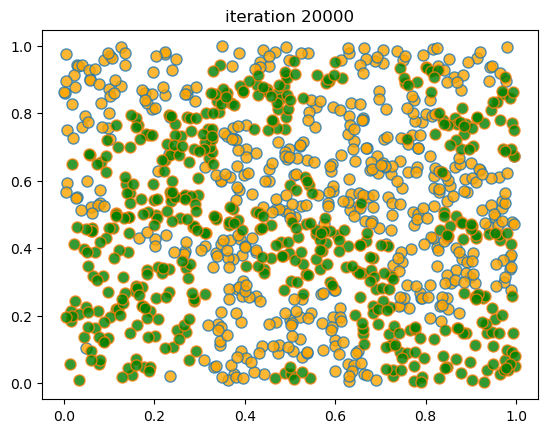

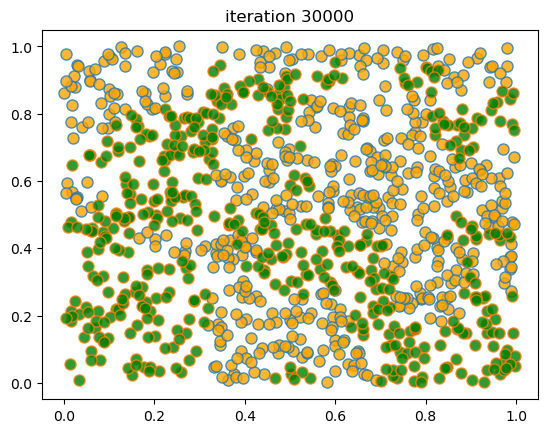

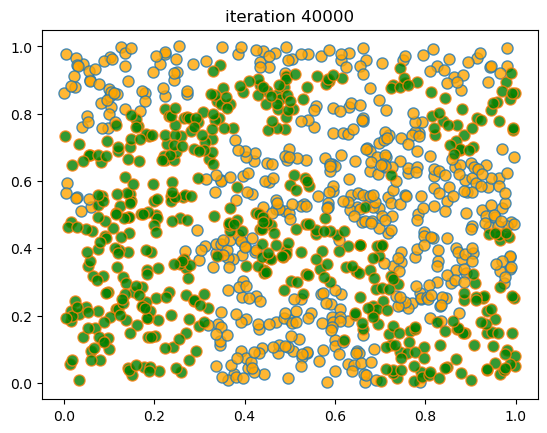

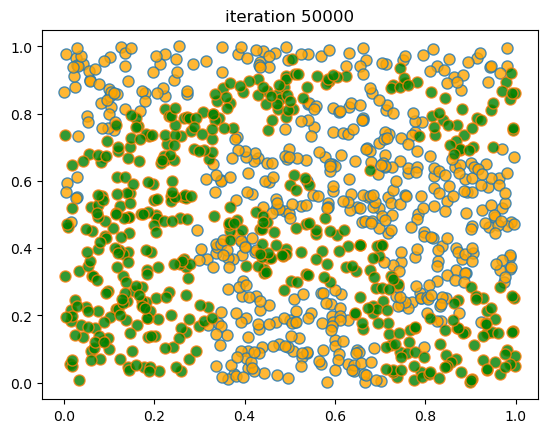

Terminating at iteration 50001


In [7]:
sim_random_select(max_iter=50_000, flip_prob=0.01, test_freq=10_000)